<h1><font size=14><center>Predictive Analytics Part</center></font></h1>
First loading the necessary libraries:

In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Custom functions and error metrics to be used later.

In [2]:
def root_mean_square_percentage_error(y_true, y_score):
    return math.sqrt(np.mean(np.power((y_true - y_score)/y_true, 2)))

root_mean_square_percentage_error_score = make_scorer(root_mean_square_percentage_error, greater_is_better=False)

def mean_absolute_percentage_error(y_true, y_score):
    return np.mean(np.absolute(y_true - y_score)/y_true)

mean_absolute_percentage_error_score = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

def printStats(test_y, pred_y):
    print('RMSE : ', math.sqrt(mean_squared_error(test_y, pred_y)))
    print('MAE  : ', mean_absolute_error(test_y, pred_y))
    print('RMSPE: ', root_mean_square_percentage_error(test_y, pred_y))
    print('MAPE : ', mean_absolute_percentage_error(test_y, pred_y))
    print('R2   : ', r2_score(test_y, pred_y))

def plotTargetVsPredict(test_y, pred_y):
    plt.figure(figsize=(8,8))

    max_val = max(test_y.max(), pred_y.max())
    min_val = min(test_y.min(), pred_y.min())

    plt.plot([min_val - 0.05*max_val, 1.05*max_val], 
             [min_val - 0.05*max_val, 1.05*max_val], color='red', linestyle='--', linewidth=2)
    plt.plot(test_y, pred_y,'o', markersize=3)

    plt.xlim([min_val - 0.05*max_val, 1.05*max_val])
    plt.ylim([min_val - 0.05*max_val, 1.05*max_val])

    plt.xlabel('Target Value')
    plt.ylabel('Predicted Value')
    plt.title('Target vs Predicted Value Distribution')

    plt.show()
    
def plotStoreTargetVsPred(df_target_pred, store):
    fig, ax = plt.subplots(figsize=(16,12))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    bp = df_target_pred.query('Store==@store').plot(x='Date', y='weekly_sales', ax=ax, x_compat=True, grid=True, style='-o', ylim=[0,2500000])
    bp = df_target_pred.query('Store==@store').plot(x='Date', y='pred_y', ax=ax, x_compat=True, grid=True, style='-o', ylim=[0,2500000])

Loading 3 files provided by the challenge:

In [3]:
df_features = pd.read_csv('features.csv', parse_dates=[1], dayfirst=True)
df_sales = pd.read_csv('sales.csv', parse_dates=[2], dayfirst=True)
df_stores = pd.read_csv('stores.csv')

Features file contains some features per store per each week. Sales file contains the sales per week per department per store. Stores file contains the type and size of the store. The assignment requires to predict the weekly sales of stores in 2012 using data from 2010-2011. Therefore, firstly, I aggregated the weekly sales of stores over the departments, and added the count of departments at store each week. I also added week of the year information as well to be able to capture seasonality effect:

In [4]:
df_sales_agg = df_sales.groupby(['Store', 'Date']).Weekly_Sales.agg({'weekly_sales':'sum', 'dept_count':'count'}).reset_index()
df_sales_agg['week'] = df_sales_agg['Date'].dt.week

/home/hdpadmin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


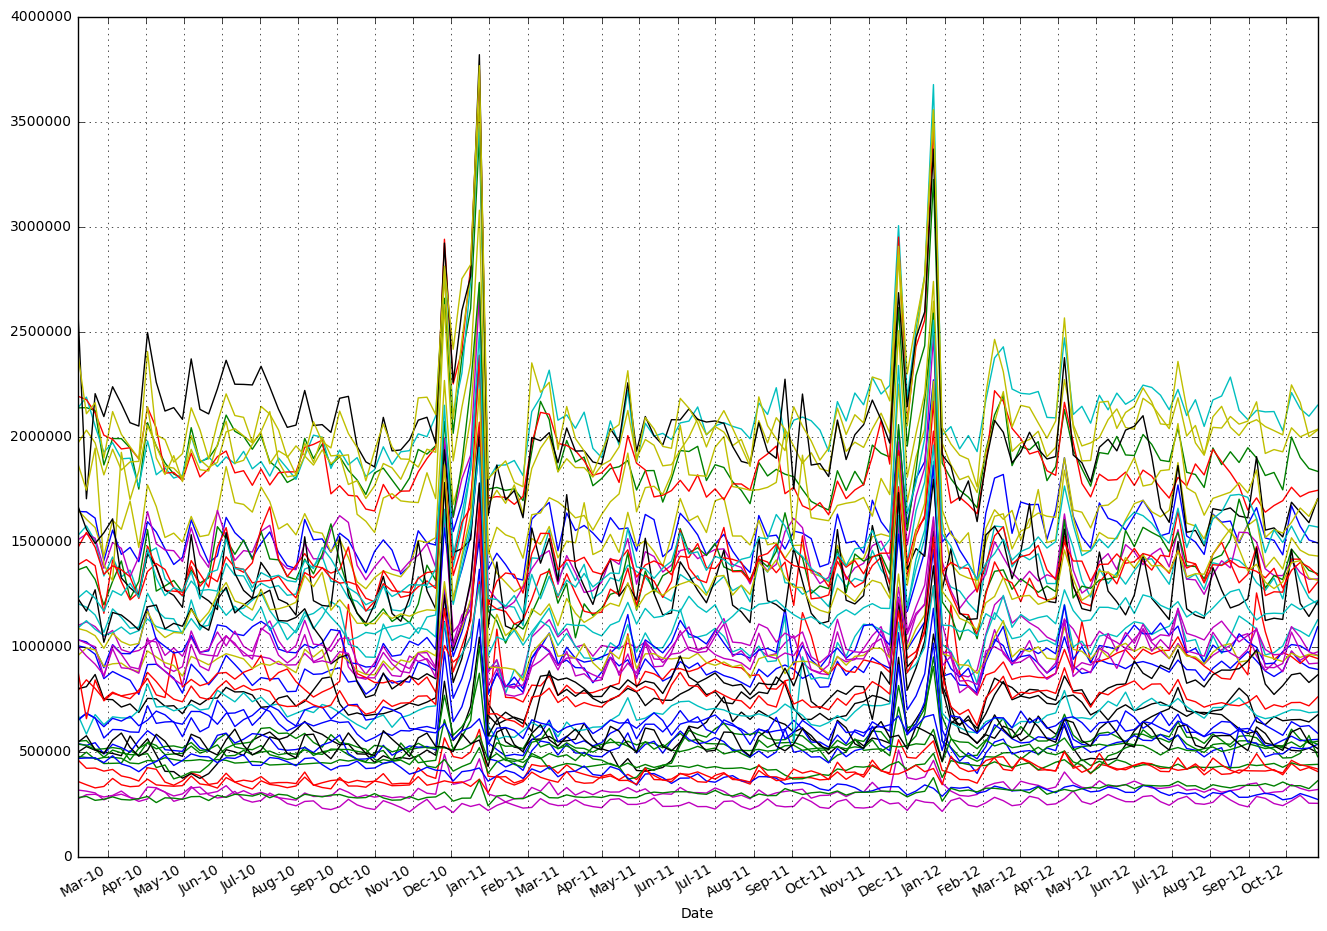

In [5]:
fig, ax = plt.subplots(figsize=(16,12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
bp = df_sales_agg.groupby('Store').plot(x='Date', y='weekly_sales', ax=ax, legend=False, x_compat=True, grid=True)
# bp = df_features.groupby('Store').plot(x='Date', y='Fuel_Price', ax=ax, legend=False, x_compat=True, grid=True)

First observations for the aggegated sales data:
- Sales make a really high peak at end of November, and at end of December due to Thanksgiving, Christmas amd New's Year Eve
- There some fluctuations over months, and also within the month itself.
- Features except Markdowns are available over the period from 2010 till 2012. Markdowns are only available after December 2011. Therefore, they have to be excluded from the analysis.
- From the weekly sales plot above, the same sales behavior repeats over time and there is high autoregressive dependency on previous sales amounts. 

Therefore, I decided to add extra features derived from autoregressive statistics:
1. Sales amounts 1, 2, 3 and 4 weeks before the prediction day.
2. Rollling window averages over 2, 3, and 4 weeks before the prediction day.
3. Monthly sales changes 2, 3, and 4 weeks before the prediction day.

Because the problem is about predicting sales, how many days/weeks/months before we are able to make proper predictions is quite important. Therefore, I have determined the prediction date by week_before variable. However, not every feature is changing a lot or at all over this prediction gap period. For example, the size of store is fixed, or the temperature and oil prices and so on not changing a lot over 1-4 weeks period. Therefore, I used the feature values of the day we make prediction for, but for autoregressive components that I derived, I shifted the values accordingly because model should be able to make future prediction based on current and previous week values.

In [6]:
week_before = 1
df_merged = df_sales_agg.merge(df_features, on=['Store', 'Date']).merge(df_stores, on='Store')
df_merged['sales_1_w_before'] = df_merged.groupby('Store').weekly_sales.shift(week_before)
df_merged['sales_2_w_before'] = df_merged.groupby('Store').weekly_sales.shift(week_before+1)
df_merged['sales_3_w_before'] = df_merged.groupby('Store').weekly_sales.shift(week_before+2)
df_merged['sales_4_w_before'] = df_merged.groupby('Store').weekly_sales.shift(week_before+3)
df_merged['avg_2w_sales_1_w_before'] = df_merged.groupby('Store').weekly_sales.shift(week_before).rolling(2).mean()
df_merged['avg_3w_sales_1_w_before'] = df_merged.groupby('Store').weekly_sales.shift(week_before).rolling(3).mean()
df_merged['avg_4w_sales_1_w_before'] = df_merged.groupby('Store').weekly_sales.shift(week_before).rolling(4).mean()
df_merged['diff_2w_sales_1_w_before'] = df_merged.groupby('Store').weekly_sales.shift(week_before).rolling(2).apply(lambda x: x[-1] - x[0])
df_merged['diff_3w_sales_1_w_before'] = df_merged.groupby('Store').weekly_sales.shift(week_before+1).rolling(2).apply(lambda x: x[-1] - x[0])
df_merged['diff_4w_sales_1_w_before'] = df_merged.groupby('Store').weekly_sales.shift(week_before+2).rolling(2).apply(lambda x: x[-1] - x[0])
df_final = df_merged.query('avg_4w_sales_1_w_before==avg_4w_sales_1_w_before')
df_final.fillna(-9999, inplace=True)
df_final['Type'] = df_final['Type'].astype('category').cat.codes

/home/hdpadmin/anaconda3/lib/python3.5/site-packages/pandas-0.20.3-py3.5-linux-x86_64.egg/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/home/hdpadmin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
df_final.describe()

,Store,dept_count,weekly_sales,week,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,sales_1_w_before,sales_2_w_before,sales_3_w_before,sales_4_w_before,avg_2w_sales_1_w_before,avg_3w_sales_1_w_before,avg_4w_sales_1_w_before,diff_2w_sales_1_w_before,diff_3w_sales_1_w_before,diff_4w_sales_1_w_before
count,6255.000000,6255.000000,6.255000e+03,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,...,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03
mean,23.000000,65.504556,1.046664e+06,26.374101,61.365244,3.377791,-3855.361416,-6539.717901,-6286.809228,-5819.924660,...,1.046413e+06,1.046917e+06,1.047270e+06,1.047619e+06,1.046665e+06,1.046866e+06,1.047055e+06,-5.043298e+02,-3.530237e+02,-3.491768e+02
std,12.988211,8.481942,5.642170e+05,13.938938,18.133689,0.450536,9498.304587,7498.903013,7520.450219,7088.751704,...,5.641935e+05,5.646450e+05,5.649250e+05,5.654362e+05,5.574210e+05,5.545518e+05,5.527178e+05,1.772109e+05,1.773434e+05,1.777489e+05
min,1.000000,38.000000,2.099863e+05,1.000000,-2.060000,2.513000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,2.099863e+05,2.099863e+05,2.099863e+05,2.099863e+05,2.238571e+05,2.248902e+05,2.319302e+05,-2.194970e+06,-2.194970e+06,-2.194970e+06
25%,12.000000,65.000000,5.542012e+05,15.000000,48.610000,2.961000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,5.542012e+05,5.540650e+05,5.540650e+05,5.538695e+05,5.563479e+05,5.552026e+05,5.557621e+05,-3.896350e+04,-3.894071e+04,-3.876412e+04
50%,23.000000,69.000000,9.592291e+05,26.000000,63.440000,3.476000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,9.592291e+05,9.601156e+05,9.604761e+05,9.604761e+05,9.638116e+05,9.670493e+05,9.679715e+05,-1.247030e+03,-1.366290e+03,-1.051910e+03
75%,34.000000,71.000000,1.419414e+06,38.000000,75.325000,3.742500,2522.930000,1.740000,4.245000,379.465000,...,1.419105e+06,1.419679e+06,1.421209e+06,1.421209e+06,1.416756e+06,1.417117e+06,1.420211e+06,4.061763e+04,4.085412e+04,4.102680e+04
max,45.000000,75.000000,3.818686e+06,52.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,...,3.818686e+06,3.818686e+06,3.818686e+06,3.818686e+06,3.292940e+06,3.112668e+06,2.938513e+06,1.081111e+06,1.081111e+06,1.081111e+06


I have splitted data into training and test datasets:
- Train dataset is all entries up until 01-01-2012.
- Test datasets is all entries after 01-01-2012.

As I mentioned, Markdowns are only availabe in after November 2011. Therefore, it doesnot make sense to use them in the model. Also, the date and store id are not relevant for the modelling. 19 features that go into model are as follows:
1. Department count
2. Week of the year
3. 7 features provided by data: Temperature, Fuel_Price, CPI, Unemployment, IsHoliday, Type, Size
4. 10 autoregressive statistics that I have derived as explained above

Weekly sales of the store is the target that the model is aiming at.

In [8]:
df_train = df_final.query("Date < '2012-01-01'").sort_values(by=['Date', 'Store'])
df_test = df_final.query("Date >= '2012-01-01'")

In [9]:
train_X = df_train.drop(['Store', 'Date', 'weekly_sales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], 1)
train_y = df_train.weekly_sales

test_X = df_test.drop(['Store', 'Date', 'weekly_sales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], 1)
test_y = df_test.weekly_sales

In [10]:
len(train_X.columns)

19

Neural Networks, especially Recurrent Neural Network (LSTM) architectures, usually outperform over the baseline algorithms. However, they have more fine-tuning parameters like architecture type, number of layers, tyep of activation function, initialization type, drop-out ratio, and so forth. They usually require a lot of data to be able to fine-tune this much of complexity. Also, the grid-search space increases tremendously, and therefore GPU or special processors (like TPUs) are used to run these calculations in parallel. Given the data size, and time available, I didnot use Neural Networks in this work.

Given the time-series forecasting nature, there are also statistical forecasting models developed in electrical engineering, signal processing, control system theory, econometrics, and finance. Most popular and well-knowns ones are linear time series models like Autoregressive Integrated Moving Average (ARIMA), and models whose parameters that can adapt over the time in trainin based on observations like State Space models, and Kalman Filters. These models are availabe in statsmodels package and that package wasn't availabe on my machine. Therefore, I had to skiped them, too.

Therefore, in this work, I have tested models with RandomForest (RF) and GradientBoosting (GBM) regressor algorithms which are the best off-the-shelf baseline algorithms, and they usually perform the best among classical models.

Hyperparamater tuning is an quite important step to find the best classifier and to decrease the overfitting in the model. The way to find the best parameters is to train the model over a bunch of parameters set. And the model with best validation result is chosen as the best estimator. This process is called grid-search. Also, validation result is decided via cross-validation where various models are developed on training data by using k-fold cross validation. K is usually chosen 5 or 10. For each fold, a performance metric is calculated, and at the end, all K results are averaged to give the performance score to the model. After choosing the best model with hyperparameters, the chosen best model is trained on train data, and tested against holdout data to get the final performance, and the modelling tuning is stopped after that point.

However, in time-series forecasting you can not directly use random k-fold cross-validation due to temporal and autoregressive dependencies. Therefore, backtesting methods should be applied. There are 2 methods:
1. __Multiple Train-Test Splits__ which preserves the temporal order of observations.
2. __Forward-Walk Validation__ where a model is being fitted/adapted each time step as new data comes available.

In this work, I followed first option as it is basically a different version of cross-validation with same idea, and chosen algortims doesnot require to be updated at step of observations.

Another important point to consider is the the scoring metric that is used in optimization. There are 4 main scorings that could be used:
1. __MSE__: Mean Squared Error
2. __MAE__: Mean Absolute Error
3. __MSPE__: Mean Squared Percentage Error
4. __MAPE__: Mean Absolute Percentage Error

First two would not be logical option as the sales amounts over stores varies a lot. To unify the respective performance, I have chosen the last one as the scoring as it includes the percentages, and it is resistent spiky/noise behaviour in the data.

In [11]:
reg_rf = RandomForestRegressor(n_jobs=-1)
param_grid_rf = {"max_depth": [2, 3, None],
              "max_features": [2, 3, 4, 5, 6, 7, None],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "criterion": ['mse'],
              "n_estimators": [300, 400, 500, 750, 1000]}

In [12]:
reg_gb = GradientBoostingRegressor()
param_grid_gb = {"loss": ['ls', 'lad'], 
              "learning_rate" : [0.05, 0.1, 0.2, 0.3, 0.5, 0.6],
              "n_estimators" : [300, 400, 500, 750, 1000], 
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 2, 3, 10],
              "max_depth": [1, 2, 3]}

In [13]:
my_cv_gb = TimeSeriesSplit(n_splits=5).split(train_X)
my_cv_rf = TimeSeriesSplit(n_splits=5).split(train_X)

# scoring = 'neg_mean_absolute_error'
# scoring = 'neg_mean_squared_error'
# scoring = root_mean_square_percentage_error_score
scoring = mean_absolute_percentage_error_score

grid_cv_gb = GridSearchCV(reg_gb, param_grid_gb, scoring = scoring, n_jobs=-1, cv = my_cv_gb, verbose = 1)
grid_cv_rf = GridSearchCV(reg_rf, param_grid_rf, scoring = scoring, n_jobs=-1, cv = my_cv_rf, verbose = 1)

grid_cv_gb.fit(train_X, train_y)
grid_cv_rf.fit(train_X, train_y)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 429 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 782 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 1232 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 1782 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2432 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3182 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4032 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 4982 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 6032 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 7182 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 8432 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 9782 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 10800 out of 10800 | elapsed:  6.5min finished


Fitting 5 folds for each of 945 candidates, totalling 4725 fits


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 1122 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2322 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3072 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3922 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 4725 out of 4725 | elapsed:  6.4min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f83e4936360>,
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [2, 3, 4, 5, 6, 7, None], 'n_estimators': [300, 400, 500, 750, 1000], 'criterion': ['mse'], 'max_depth': [2, 3, None], 'min_samples_leaf': [1, 3, 10], 'min_samples_split': [2, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
       verbose=1)

In [14]:
print('gb : ' , grid_cv_gb.best_score_)
print('rf : ' , grid_cv_rf.best_score_)

gb :  -0.07109757838870358
rf :  -0.07245890217724073


After training the both models over gridsearch, the scores of GBM is slightly better than RF. Stacking is also another form of ensemble method and merged hybrid model usually performs better than the consitutent models. Therefore, I wanted to blend the results of coming from each model, and see if there is any improvement. Therefore, I run the small grid-search for blending factor:

In [15]:
hybrid_blending = {}
for alpha in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    print('alpha', alpha)
    hybrid_blending[alpha] = []
    for train_index, test_index in TimeSeriesSplit(n_splits=5).split(train_X):
        train_X_CV_fold, test_X_CV_fold = train_X.iloc[train_index], train_X.iloc[test_index]
        train_y_CV_fold, test_y_CV_fold = train_y.iloc[train_index], train_y.iloc[test_index]
                
        pred_y_gb_CV_fold = grid_cv_gb.best_estimator_.fit(train_X_CV_fold, train_y_CV_fold).predict(test_X_CV_fold)
        pred_y_rf_CV_fold = grid_cv_rf.best_estimator_.fit(train_X_CV_fold, train_y_CV_fold).predict(test_X_CV_fold)
        
        pred_y_CV_fold = alpha*pred_y_gb_CV_fold + (1-alpha)*pred_y_rf_CV_fold
        
        hybrid_blending[alpha].append(mean_absolute_percentage_error(test_y_CV_fold, pred_y_CV_fold))

alpha 0
alpha 0.1
alpha 0.2
alpha 0.3
alpha 0.4
alpha 0.5
alpha 0.6
alpha 0.7
alpha 0.8
alpha 0.9
alpha 1


In [16]:
for key in sorted(hybrid_blending.keys()):
    print(key, 100*np.mean(hybrid_blending[key]), 100*np.std(hybrid_blending[key]))

0 7.254088211565531 3.3838619933567493
0.1 7.172901315802774 3.3667188942437294
0.2 7.138677205368733 3.3574758021166455
0.3 7.076541275838218 3.3549902051282476
0.4 7.068615896296236 3.2809940698660065
0.5 7.05589191910872 3.30780216850722
0.6 6.997748559802967 3.321011536985379
0.7 7.03225171896794 3.2801308180396997
0.8 7.130291141889744 3.320136831535418
0.9 7.115598464818953 3.244154112865881
1 7.124713707175823 3.3122953368054238


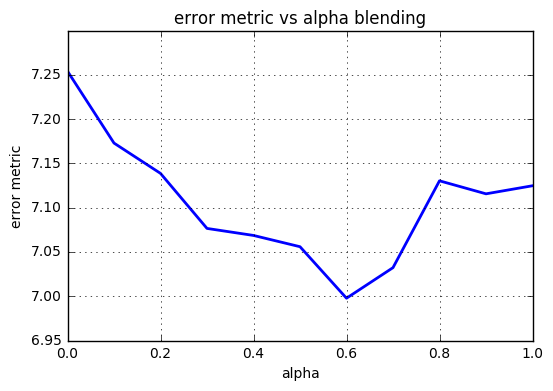

In [17]:
a  = sorted(hybrid_blending.keys())
mu = np.array([100*np.mean(hybrid_blending[key]) for key in sorted(hybrid_blending.keys())])
sigma = np.array([100*np.std(hybrid_blending[key]) for key in sorted(hybrid_blending.keys())])

fig, ax = plt.subplots(1)
ax.plot(a, mu, lw=2, color='blue')
ax.set_title('error metric vs alpha blending')
ax.set_xlabel('alpha')
ax.set_ylabel('error metric')
ax.grid()

As it can be seen from the graph, there is a slightly better minimum can be achieved around alpha=0.5. Therefore, it is wise to keep the blending at 0.5:

In [18]:
pred_y_gb = grid_cv_gb.best_estimator_.fit(train_X, train_y).predict(test_X)
pred_y_rf = grid_cv_rf.best_estimator_.fit(train_X, train_y).predict(test_X)

pred_y = (pred_y_gb + pred_y_rf)/2

Now we can calculate the error statistics for the 2012 test data, and plot the scatter distribution of the predicted and target values:

RMSE :  73988.66289860266
MAE  :  49380.935489072945
RMSPE:  0.06588481722927254
MAPE :  0.04828737463635453
R2   :  0.9809819056890567


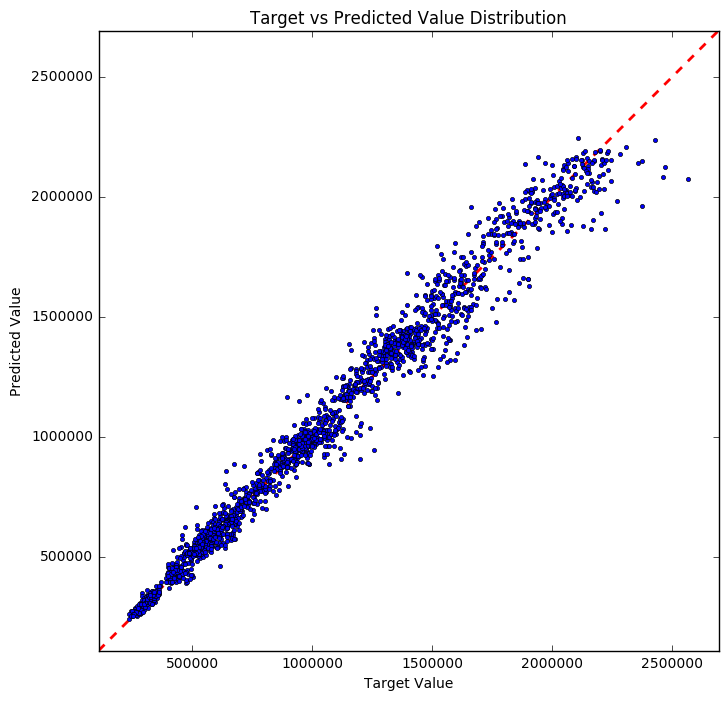

In [19]:
printStats(test_y, pred_y)
plotTargetVsPredict(test_y, pred_y)

RSME, MAE, RMSPE, and MAPE should be as small as possible, and not a lot different the test results (otherwise it would imply generalization problem), and R2 score should be as close to 1 as possible.

Future work, and additional improvement points:
1. Try with RNN architectures, especially LSTM.
2. Try with linear time-series models like ARIMA.
3. Work on different type of features.
4. Try to better capture trend and seasonality in the data.
5. Try with bigger grid search.
6. Try to change the grid search in a way that predictions of stores are optimized independently.
7. weeks_before is important parameter, and clear requirement would be beneficial.

In [20]:
df_target_pred = df_test[['Store', 'Date', 'weekly_sales']].copy()
df_target_pred['pred_y'] = pred_y

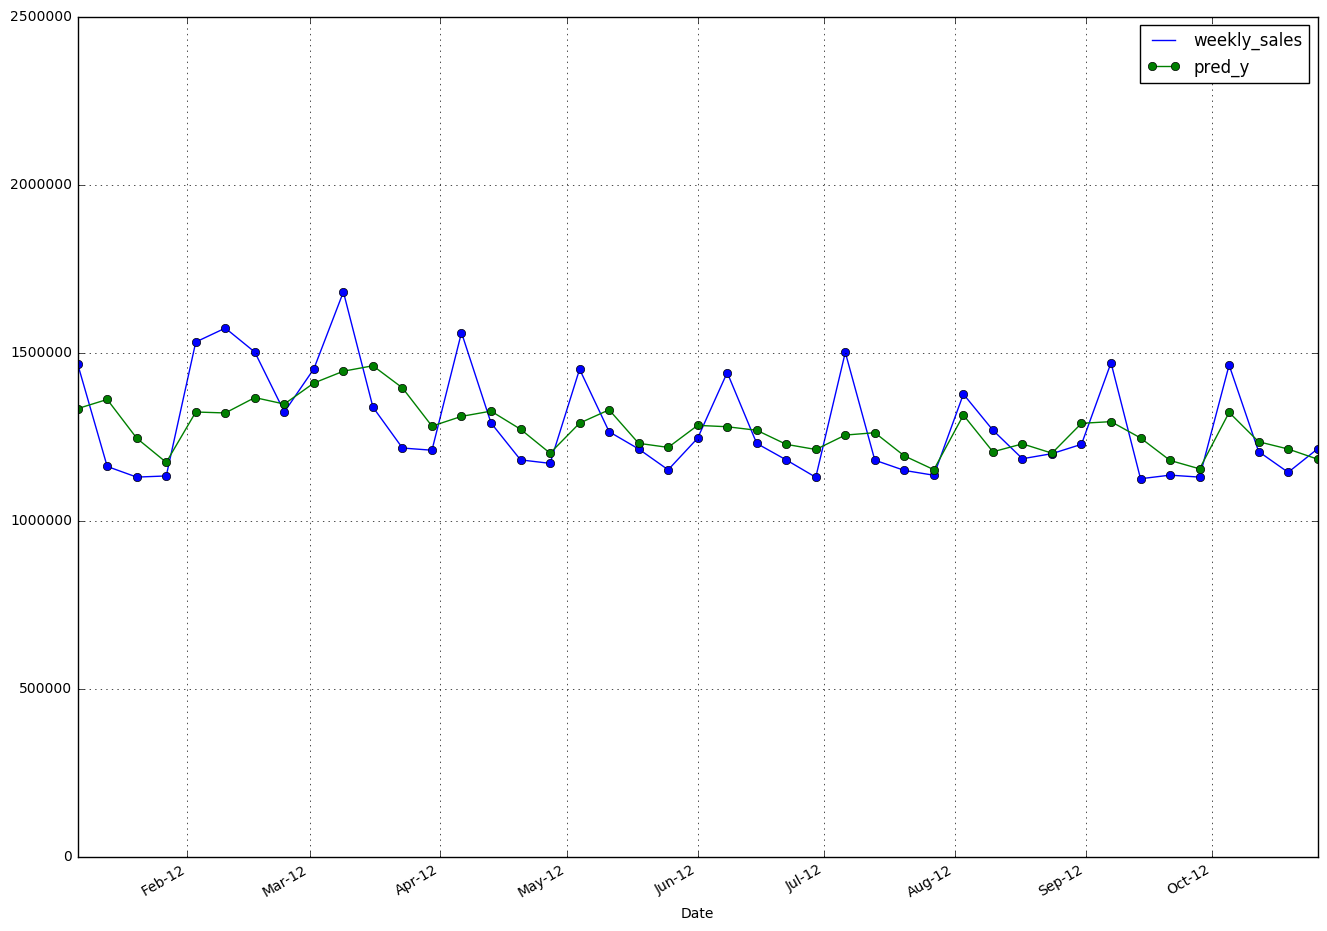

In [23]:
plotStoreTargetVsPred(df_target_pred, 28)